# ArangoDB 🥑 + LangChain 🦜🔗

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/Langchain.ipynb)

Large language models (LLMs) ~are emerging~ have emerged as a transformative technology, enabling developers to build applications that they previously could not. However, using these LLMs in isolation is often insufficient for creating a truly powerful app - the real power comes when you can combine them with other sources of computation or knowledge.

[LangChain](https://www.langchain.com/) is a framework for developing applications powered by language models. It enables applications that are:
- Data-aware: connect a language model to other sources of data
- Agentic: allow a language model to interact with its environment

This notebook will leverage LLMs to provide a natural language interface to querying ArangoDB.

**Please note**: We'll be using the LangChain `ChatOpenAI` wrapper, which requires you to have a **paid** [OpenAI API Key](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key). However, other Chat Models are available as well: https://github.com/langchain-ai/langchain/tree/master/libs/langchain/langchain/chat_models

In [ ]:
%%capture

# Set your OpenAI API Key
# https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key

!pip install langchain==0.0.314
!pip install openai==0.28.1

import os

os.environ["OPENAI_API_KEY"] = "sk-..."


## LangChain 101

There are six basic components of Langchain:
- **Models**: the library of LLMs to choose from
- **Prompts**: text that guides the LLM to generate the desired output
- **Chains**: sequences of instructions the LangChain framework executes to perform a task
- **Memory**: a method of storing data for the LLM to access later
- **Agents & Tools**: the essential components to perform specific tasks based on user context
- **Indexes, Vectorstores, & Retrievers**: the essential components to building an app on your specific data

In [ ]:
# 1. Install dependencies

%%capture
!pip install wikipedia==1.4.0
!pip install sentence_transformers==2.2.2
!pip install faiss-cpu==1.7.4
!pip install chromadb==0.4.15
!pip install tiktoken==0.5.1

In [ ]:
# 2. Basic Prompting

from langchain.llms import OpenAI

model = OpenAI(temperature=0)

print(model("What is ArangoDB?"))

In [ ]:
# 3. Prompting with Templates

from langchain import PromptTemplate

template = """
  Question: {question}
  Explain like I'm five!
"""

prompt = PromptTemplate(template=template, input_variables=["question"])

print(model(prompt.format(question="What is ArangoDB?")))

In [ ]:
# 4. Prompting with Chains

from langchain import LLMChain

chain = LLMChain(prompt=prompt, llm=model)

question = "What is ArangoDB?"

print(chain.run(question))

In [ ]:
# 5. Prompting with Memory

from langchain import OpenAI, ConversationChain

model = OpenAI(temperature=0)

conversation = ConversationChain(llm=model, verbose=True)

conversation.predict(input="How old is C++?")
conversation.predict(input="Sorry I meant ArangoDB")

In [ ]:
# 6. Prompting via Agent

from langchain.agents import load_tools
from langchain.agents import initialize_agent

model = OpenAI(temperature=0)

tools = load_tools(["wikipedia", "llm-math"], llm=model)

agent = initialize_agent(tools, model, agent="zero-shot-react-description", verbose=True)

agent.run("What is 2 + 2")
agent.run("How old is ArangoDB?")

In [ ]:
# 7. Prompting with Indexes (1): Data Load

# Using ChromaDB & LangChain to perform question answering over documents.

from langchain.document_loaders import TextLoader
import requests

# Fetch some sample data
url = "https://raw.githubusercontent.com/hwchase17/chroma-langchain/master/state_of_the_union.txt"
res = requests.get(url)

with open("state_of_the_union.txt", "w") as f:
  f.write(res.text)

# Load documents
loader = TextLoader('state_of_the_union.txt')
documents = loader.load()

len(documents)

In [ ]:
# 7. Prompting with Indexes (2): Text Splitting

# Next: splitting documents into small chunks.
# This is so we can find the most relevant chunks
# for a query and pass only those into the LLM.

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text Splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

len(texts)

In [ ]:
# 7. Prompting with Indexes (3): Initialize PeristedChromaDB

# Create embeddings for each chunk and insert
# into the Chroma vector database.
# The persist_directory argument tells ChromaDB
# where to store the database when it's persisted.

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Embed and store the texts
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=texts, embedding=embedding)

vectordb

In [ ]:
# 7. Prompting with Indexes (5): Create the chain
from langchain.chains.retrieval_qa.base import VectorDBQA

chain = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=vectordb)

In [ ]:
# 7. Prompting with Indexes (6): Asking questions

print(chain.run("TL;DR the president's message for me"))
print('-'*100)
print(chain.run("What did the president say specifically about Russian oligarchs?"))
print('-'*100)
print(chain.run("How much did the President say the economy grew last year?"))

- Question-Answering in LangChain: https://python.langchain.com/docs/use_cases/question_answering/
- Integrations in LangChain: https://python.langchain.com/docs/integrations/providers

---
## Setup

### Preliminaries

In [ ]:
%%capture

# 1: Install the dependencies

!pip install python-arango # The ArangoDB Python Driver
!pip install adb-cloud-connector # The ArangoDB Cloud Instance provisioner
!pip install arango-datasets # Datasets package

In [ ]:
# 2. Helper Function Definitions

import json

def pprint(data):
  print(json.dumps(data, indent=4))

def query(db, aql):
  pprint(list(db.aql.execute(aql)))

In [ ]:
# 3. Provisioning ArangoDB

from adb_cloud_connector import get_temp_credentials

credentials = get_temp_credentials(tutorialName="LangChain")

pprint(credentials)

In [ ]:
# 4. Connecting to ArangoDB

from arango import ArangoClient

client = ArangoClient(credentials["url"], request_timeout=None)

db = client.db(
    name=credentials["dbName"],
    username=credentials["username"],
    password=credentials["password"],
    verify=True
)

db

### Loading Datasets

#### Game Of Thrones

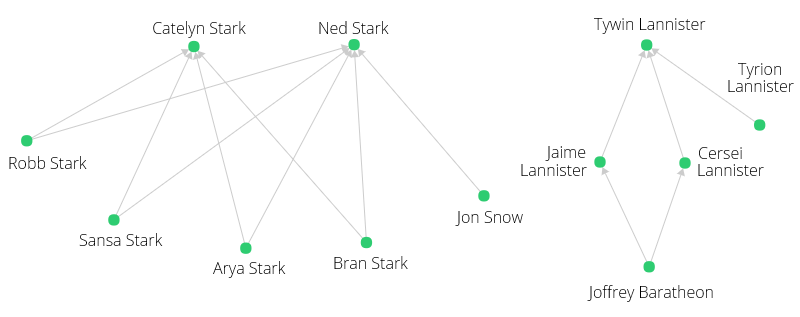

In [ ]:
# (13 nodes, 15 edges)

# This dataset represents the parent-child
# relationships of certain characters from the GoT universe

if db.has_graph("GameOfThrones"):
    db.delete_graph("GameOfThrones", drop_collections=True)


edge_definitions=[
    {
        "edge_collection": "ChildOf",
        "from_vertex_collections": ["Characters"],
        "to_vertex_collections": ["Characters"],
    }
]

documents = [
    # Starks (8)
    {"_key": "RickardStark", "name": "Rickard", "surname": "Stark", "alive": False, "age": 60, "gender": "male"},
    {"_key": "LyarraStark", "name": "Lyarra", "surname": "Stark", "alive": False, "age": 60, "gender": "female"},
    {"_key": "NedStark", "name": "Ned", "surname": "Stark", "alive": True, "age": 41, "gender": "male"},
    {"_key": "CatelynStark", "name": "Catelyn", "surname": "Stark", "alive": False, "age": 40, "gender": "female"},
    {"_key": "AryaStark", "name": "Arya", "surname": "Stark", "alive": True, "age": 11, "gender": "female"},
    {"_key": "BranStark", "name": "Bran", "surname": "Stark", "alive": True, "age": 10, "gender": "male"},
    { "_key": "RobbStark", "name": "Robb", "surname": "Stark", "alive": False, "age": 16, "gender": "male"},
    { "_key": "SansaStark", "name": "Sansa", "surname": "Stark", "alive": True, "age": 13, "gender": "female"},

    # Lannisters (4)
    { "_key": "TywinLannister", "name": "Tywin", "surname": "Lannister", "alive": False, "age": 67, "gender": "male" },
    { "_key": "JaimeLannister", "name": "Jaime", "surname": "Lannister", "alive": True, "age": 36, "gender": "male" },
    { "_key": "CerseiLannister", "name": "Cersei", "surname": "Lannister", "alive": True, "age": 36, "gender": "female" },
    { "_key": "TyrionLannister", "name": "Tyrion", "surname": "Lannister", "alive": True, "age": 32, "gender": "male" },

    # Baratheons (1)
    { "_key": "JoffreyBaratheon", "name": "Joffrey", "surname": "Baratheon", "alive": False, "age": 19, "gender": "male"},
]

edges = [
    {"_to": "Characters/NedStark", "_from": "Characters/BranStark"},
    {"_to": "Characters/NedStark", "_from": "Characters/RobbStark" },
    {"_to": "Characters/NedStark", "_from": "Characters/SansaStark" },
    {"_to": "Characters/NedStark", "_from": "Characters/AryaStark" },
    {"_to": "Characters/CatelynStark", "_from": "Characters/AryaStark"},
    {"_to": "Characters/CatelynStark", "_from": "Characters/BranStark"},
    {"_to": "Characters/CatelynStark", "_from": "Characters/RobbStark" },
    {"_to": "Characters/CatelynStark", "_from": "Characters/SansaStark" },
    {"_to": "Characters/RickardStark", "_from": "Characters/NedStark"},
    {"_to": "Characters/LyarraStark", "_from": "Characters/NedStark"},

    {"_to": "Characters/TywinLannister", "_from": "Characters/JaimeLannister" },
    {"_to": "Characters/TywinLannister", "_from": "Characters/CerseiLannister" },
    {"_to": "Characters/TywinLannister", "_from": "Characters/TyrionLannister" },
    {"_to": "Characters/CerseiLannister", "_from": "Characters/JoffreyBaratheon" },
    {"_to": "Characters/JaimeLannister", "_from": "Characters/JoffreyBaratheon" }
]

db.delete_graph("GameOfThrones", ignore_missing=True, drop_collections=True)
db.create_graph("GameOfThrones", edge_definitions)

db.collection("Characters").import_bulk(documents)
db.collection("ChildOf").import_bulk(edges)

#### GDELT Project (Open Intelligence)

> GDELT monitors the world's news media from nearly every corner of every country
in print, broadcast, and web formats, in over 100 languages,
every moment of every day. [...] Put simply, the GDELT Project is a realtime open data global graph over human society as seen through the eyes of the world's news media, reaching deeply into local events, reaction, discourse, and emotions of the most remote corners of the world in near-realtime and making all of this available as an open data firehose to enable research over human society.


In [ ]:
# (~70k nodes, ~400 edges)
# https://www.gdeltproject.org/

from arango_datasets.datasets import Datasets

Datasets(db).load("OPEN_INTELLIGENCE")

edge_definitions = [
    {
        "edge_collection": "hasLocation",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Location"],
    },
    {
        "edge_collection": "hasSource",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Source"],
    },
    {
        "edge_collection": "inCountry",
        "from_vertex_collections": ["Location"],
        "to_vertex_collections": ["Country"],
    },
    {
        "edge_collection": "inRegion",
        "from_vertex_collections": ["Country"],
        "to_vertex_collections": ["Region"],
    },
    {
        "edge_collection": "eventActor",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Actor"],
    },
    {
        "edge_collection": "subClass",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Class"],
    },
    {
        "edge_collection": "type",
        "from_vertex_collections": ["Event"],
        "to_vertex_collections": ["Class"],
    },
]

db.delete_graph("OpenIntelligence", ignore_missing=True)
db.create_graph("OpenIntelligence", edge_definitions=edge_definitions)

### Configuring LangChain

In [ ]:
# 1: Instantiate the ArangoDB-LangChain Graph wrapper

from langchain.graphs import ArangoGraph

graph = ArangoGraph(db)

pprint(graph.schema)

In [ ]:
# 2: Instantiate the OpenAI Chat model
# Note that other models can be used as well
# Ref: https://github.com/langchain-ai/langchain/tree/master/libs/langchain/langchain/chat_models

from langchain.chat_models import ChatOpenAI

model = ChatOpenAI(temperature=0, model_name='gpt-4')

In [ ]:
# 3: Instantiate the LangChain Question-Answering Chain with
# our **model** and **graph**

from langchain.chains import ArangoGraphQAChain

chain = ArangoGraphQAChain.from_llm(model, graph=graph, verbose=True)

---
## Prompting

#### Game Of Thrones

In [ ]:
chain.run("Who are the 2 youngest characters?")

In [ ]:
chain.run("How are Bran Stark and Arya Stark related?")

In [ ]:
chain.run("Who are Bran Stark’s grandparents?")

In [ ]:
chain.run("Fetch me the character count for each family")

In [ ]:
chain.run("What is the age difference between Rickard Stark and Arya Stark?")

In [ ]:
chain.run("Wie alt ist Rickard Stark?") # (German: "How old is Rickard Stark?")

In [ ]:
chain.run("What is the average age within the Stark family?")

In [ ]:
chain.run("Does Bran Stark have a dead parent?")

In [ ]:
chain.run("Add Jon Snow, 31, a male character. Use overwrite.")

In [ ]:
chain.run("Create a ChildOf edge from Jon Snow to Ned Stark.")

In [ ]:
chain.run("Who is related to Ned Stark?")

In [ ]:
chain.run("What can you tell me about the characters?")

In [ ]:
chain.run("Use the shortest path algorithm to go from Bran Stark to Rickard Stark")

In [ ]:
chain.run("What is the family tree of Joffrey Baratheon?")

In [ ]:
chain.run("What is the relationship between Bran Stark and Rickard Stark?")

In [ ]:
chain.run("Are Arya Stark and Ned Stark related?")

In [ ]:
chain.run("Is Ned Stark alive?")

In [ ]:
chain.run("Ned Stark has died. Update the data")

In [ ]:
chain.run("How many characters are alive? How many characters are dead?")

In [ ]:
chain.run("Is Arya Stark now an orphan?")

#### Open Intelligence

In [ ]:
# Set the maximum number of AQL Query Results to return to 5
# This avoids burning the LLM token limit on JSON results
chain.top_k = 5

In [ ]:
chain.run("Fetch me 3 events that happened in December 2019")

In [ ]:
chain.run("Who is responsible for 'Event/ANG3310'?")

In [ ]:
chain.run("Where did 'Event/ANG3310' take place?")

In [ ]:
chain.run("What country did 'Event/ANG3310' take place?")

In [ ]:
chain.run("What region did 'Event/ANG3310' take place?")

In [ ]:
chain.run("What is the source of 'Event/ANG3310'?")

In [ ]:
chain.run("What type of event is 'Event/ANG3310' classified as?")

In [ ]:
chain.run("What are the classes associated to 'Strategic developments'?")

In [ ]:
chain.run("Fetch me the Actor with the most associated events. Remember to use INBOUND for eventActor")

In [ ]:
chain.run("Which 2020 event has the largest number of fatalities?")

In [ ]:
chain.run("Return the first 3 countries with the most associated events")

In [ ]:
# ArangoSearch + LangChain

db.delete_view("EventView", ignore_missing=True)
db.create_view(
    "EventView",
    "arangosearch",
    {
        "links": {
            "Event": {
                "analyzers": ["text_en"],
                "fields": {
                    "description": { # <------ Enable Event search by `description`
                        "analyzers": ["text_en"],
                    },
                },
                "includeAllFields": True,
                "storeValues": "none",
                "trackListPositions": False,
            },
        }
    },
)

True

In [ ]:
print(chain.run("ArangoSearch: Fetch me events about assassinations. Use the EventView"))

In [ ]:
print(chain.run("""
  ArangoSearch: Use the EventView to fetch events that mention FARDC.
  Return each event along with its associated Class.
"""))

In [ ]:
print(chain.run("""
  ArangoSearch: Fetch me events that mention 'law students'.
  Prioritize results that have both 'law' and 'students', but not necessarily side-by-side.
  Use the EventView.
"""))

In [ ]:
db.delete_view("ActorView", ignore_missing=True)
db.create_view(
    "ActorView",
    "arangosearch",
    {
        "links": {
            "Actor": {
                "analyzers": ["text_en"],
                "fields": {
                    "name": { # <------ Enable Actor search by `name`
                        "analyzers": ["text_en"],
                    },
                },
                "includeAllFields": True,
                "storeValues": "none",
                "trackListPositions": False,
            },
        }
    },
)

True

In [ ]:
print(chain.run("ArangoSearch: Fetch me the actors whose name has 'United Nations' in it. Use the ActorView."))

In [ ]:
print(chain.run("""
  ArangoSearch: Use the ActorView to search for actors who name has 'peace' or 'justice'.
  Boost by 1 for 'peace' matches, and boost by 5 for 'justice' matches.
  Avoid actor names that match with 'mutiny'.
  Sort and list them numerically.
"""))

In [ ]:
print(chain.run("""
  ArangoSearch: Use the ActorView to fetch me Actors whose name has the word 'militia' in it.
  From those actors, fetch me the Actor with the highest number of associated events.
  With those events, return their sum of fatalities.
  Remember to use INBOUND for eventActor!
"""))

---
## Prompt Engineering

##### via Prompt Modifiers

You can alter the values of the following `ArangoDBGraphQAChain` class variables to modify the behaviour of your chain results


In [ ]:
# Notice how the following prompt returns nothing;
chain.run("Who are the grandchildren of Rickard Stark?")

In [ ]:
# A simple reminder to use INBOUND (instead of OUTBOUND) returns the correct result;
chain.run("Who are the grandchildren of Rickard Stark? Remember to use INBOUND")

In [ ]:
# We can solidify this pattern by making using of **chain.aql_examples**

# The AQL Examples modifier instructs the LLM to adapt its AQL-completion style
# to the user’s examples. These examples arepassed to the AQL Generation Prompt
# Template to promote few-shot-learning.

chain.aql_examples = """
# Who are the grandchildren of Rickard Stark?
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/RickardStark' ChildOf
  RETURN v

# Is Ned Stark alive?
RETURN DOCUMENT('Characters/NedStark').alive
"""

# Note how we are no longer specifying the use of INBOUND
chain.run("Who are the grandchildren of Tywin Lannister?")

In [ ]:
# Other modifiers include:

# Specify the maximum number of AQL Query Results to return
chain.top_k = 5

# Specify the maximum amount of AQL Generation attempts that should be made
# before returning an error
chain.max_aql_generation_attempts = 5

# Specify whether or not to return the AQL Query in the output dictionary
# Use `chain("...")` instead of `chain.run("...")` to see this change
chain.return_aql_query = True

# Specify whether or not to return the AQL JSON Result in the output dictionary
# Use `chain("...")` instead of `chain.run("...")` to see this change
chain.return_aql_result = True

##### via Prompt Templates

In [ ]:
from langchain.prompts import PromptTemplate

###### Natural Language to AQL Template

In [ ]:
AQL_GENERATION_TEMPLATE = """Task: Generate an ArangoDB Query Language (AQL) query from a User Input.

You are an ArangoDB Query Language (AQL) expert responsible for translating a `User Input` into an ArangoDB Query Language (AQL) query.

You are given an `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You may also be given a set of `AQL Query Examples` to help you create the `AQL Query`. If provided, the `AQL Query Examples` should be used as a reference, similar to how `ArangoDB Schema` should be used.

Things you should do:
- Think step by step.
- Rely on `ArangoDB Schema` and `AQL Query Examples` (if provided) to generate the query.
- Begin the `AQL Query` by the `WITH` AQL keyword to specify all of the ArangoDB Collections required.
- Return the `AQL Query` wrapped in 3 backticks (```).
- Use only the provided relationship types and properties in the `ArangoDB Schema` and any `AQL Query Examples` queries.
- Only answer to requests related to generating an AQL Query.
- If a request is unrelated to generating AQL Query, say that you cannot help the user.

Things you should not do:
- Do not use any properties/relationships that can't be inferred from the `ArangoDB Schema` or the `AQL Query Examples`.
- Do not include any text except the generated AQL Query.
- Do not provide explanations or apologies in your responses.
- Do not generate an AQL Query that removes or deletes any data.

Under no circumstance should you generate an AQL Query that deletes any data whatsoever.

ArangoDB Schema:
{adb_schema}

AQL Query Examples (Optional):
{aql_examples}

User Input:
{user_input}

AQL Query:
"""

AQL_GENERATION_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "aql_examples", "user_input"],
    template=AQL_GENERATION_TEMPLATE,
)

###### AQL to AQL Template

In [ ]:
AQL_FIX_TEMPLATE = """Task: Address the ArangoDB Query Language (AQL) error message of an ArangoDB Query Language query.

You are an ArangoDB Query Language (AQL) expert responsible for correcting the provided `AQL Query` based on the provided `AQL Error`.

The `AQL Error` explains why the `AQL Query` could not be executed in the database.
The `AQL Error` may also contain the position of the error relative to the total number of lines of the `AQL Query`.
For example, 'error X at position 2:5' denotes that the error X occurs on line 2, column 5 of the `AQL Query`.

You are also given the `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You will output the `Corrected AQL Query` wrapped in 3 backticks (```). Do not include any text except the Corrected AQL Query.

Remember to think step by step.

ArangoDB Schema:
{adb_schema}

AQL Query:
{aql_query}

AQL Error:
{aql_error}

Corrected AQL Query:
"""

AQL_FIX_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "aql_query", "aql_error"],
    template=AQL_FIX_TEMPLATE,
)

###### JSON to Natural Language Template

In [ ]:
AQL_QA_TEMPLATE = """Task: Generate a natural language `Summary` from the results of an ArangoDB Query Language query.

You are an ArangoDB Query Language (AQL) expert responsible for creating a well-written `Summary` from the `User Input` and associated `AQL Result`.

A user has executed an ArangoDB Query Language query, which has returned the AQL Result in JSON format.
You are responsible for creating an `Summary` based on the AQL Result.

You are given the following information:
- `ArangoDB Schema`: contains a schema representation of the user's ArangoDB Database.
- `User Input`: the original question/request of the user, which has been translated into an AQL Query.
- `AQL Query`: the AQL equivalent of the `User Input`, translated by another AI Model. Should you deem it to be incorrect, suggest a different AQL Query.
- `AQL Result`: the JSON output returned by executing the `AQL Query` within the ArangoDB Database.

Remember to think step by step.

Your `Summary` should sound like it is a response to the `User Input`.
Your `Summary` should not include any mention of the `AQL Query` or the `AQL Result`.

ArangoDB Schema:
{adb_schema}

User Input:
{user_input}

AQL Query:
{aql_query}

AQL Result:
{aql_result}

Use sarcasm in your answer!
"""


AQL_QA_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "user_input", "aql_query", "aql_result"],
    template=AQL_QA_TEMPLATE,
)

###### Reconfiguring LangChain

In [ ]:
sarcastic_chain = ArangoGraphQAChain.from_llm(
    model,
    aql_generation_prompt=AQL_GENERATION_PROMPT,
    aql_fix_prompt=AQL_FIX_PROMPT,
    qa_prompt=AQL_QA_PROMPT,
    graph=graph,
    verbose=True
)

In [ ]:
sarcastic_chain.run("Is Ned Stark alive?")

---
## Fine-Tuning

https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model

In [ ]:
# 1. Load the Training Data

import json

training_data = [
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    # ...
]

with open('aql.jsonl', 'w') as f:
    for entry in training_data:
        json_str = json.dumps(entry)
        f.write(json_str + '\n')

In [ ]:
# 2. Create the OpenAI File

import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

openai_file = openai.File.create(
  file=open("aql.jsonl", "rb"),
  purpose='fine-tune'
)

openai_file

In [ ]:
# 3. Trigger the Fine Tuning Job

job = openai.FineTuningJob.create(training_file=openai_file["id"], model="gpt-3.5-turbo")

job

In [ ]:
# 4. Wait for the Job to complete

import time
from datetime import datetime
from IPython.display import clear_output

job_status = job['status']
while job['finished_at'] == None:
    print(datetime.now().isoformat(), job_status)

    time.sleep(5)
    clear_output(wait=True)

    job = openai.FineTuningJob.retrieve(job["id"])
    job_status = job['status']

print('done!')

In [ ]:
# 5. Instantiate the OpenAI wrapper with the fine-tuned model

ft_model = ChatOpenAI(temperature=0, model=job.fine_tuned_model)

In [ ]:
# 6. Re-instantiate the ArangoGraphQAChain object

ft_chain = ArangoGraphQAChain.from_llm(ft_model, graph=graph, verbose=True)

In [ ]:
chain.run("When did Event/ALG7745 occur?")
chain.run("How old is Ned Stark?")

In [ ]:
ft_chain.run("When did Event/ALG7745 occur?")
ft_chain.run("How old is Ned Stark?")

---
## More Info

- [ArangoDB: LLMs + Knowledge Graphs](https://arangodb.com/llm-knowledge-graph/)

- [ArangoDB Empowers Large Language Models for Real-World Applications](https://arangodb.com/2023/08/bridging-knowledge-and-language-arangodb-empowers-large-language-models-for-real-world-applications/)